## Introduction

**This project is based on the movielens dataset ,which has been used to build a recommendation system, based on the movies watched by users**

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import requests
import os
import pathlib
import zipfile
import io
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import json

from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import warnings
warnings.filterwarnings('ignore',category=pd.errors.SettingWithCopyWarning)



In [2]:
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset

#!pip install torchmetrics
#!pip install optuna
#!pip install torchinfo

import torchmetrics
import optuna
import torchinfo



In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
#Movielens link
link="https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

In [5]:
#Downloading and unzipping the link
response=requests.get(link)
filename='movie.zip'

with open(filename, 'wb') as f:
   f.write(response.content)

with zipfile.ZipFile(filename,'r') as zip_ref:
  zip_ref.extractall()

In [6]:
#Reading contents of file
data_dir=pathlib.Path('ml-latest-small')
os.listdir(data_dir)

['README.txt', 'tags.csv', 'movies.csv', 'ratings.csv', 'links.csv']

## Understanding the data

In [7]:
rating_df=pd.read_csv(data_dir/'ratings.csv')
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
movie_df=pd.read_csv(data_dir/'movies.csv')
movie_df.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
#Creating dictionaries of movie to id for easy reference
dict_idtomovie=dict(zip(movie_df['movieId'], movie_df['title']))
dict_movietoid={m:i for i,m in dict_idtomovie.items() }

In [10]:
tags_df=pd.read_csv(data_dir/'tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [11]:
links_df=pd.read_csv(data_dir/'links.csv')
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [12]:
#Creating a cross table to map movie rating with user
df=rating_df.drop('timestamp',axis=1)
pivot_df=df.pivot_table(values='rating',index='userId',columns='movieId')
pivot_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


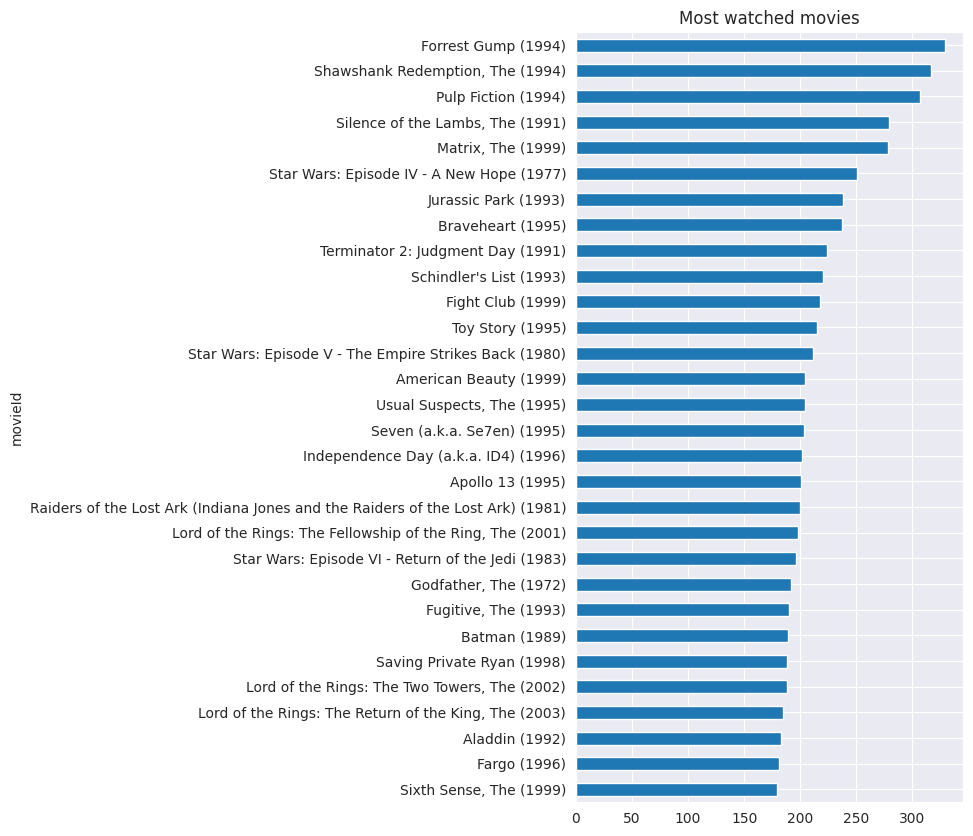

In [13]:
#Most watched movies
temp_df=pivot_df.count(axis=0).sort_values(ascending=False).head(30)
labels=[dict_idtomovie[x] for x in temp_df.index.to_list()]

fig=plt.figure(figsize=(5,10))
temp_df.plot(kind='barh')
plt.yticks(ticks=range(len(temp_df.index.to_list())),labels=labels,rotation=0)
plt.title('Most watched movies')
plt.gca().invert_yaxis()
plt.show()


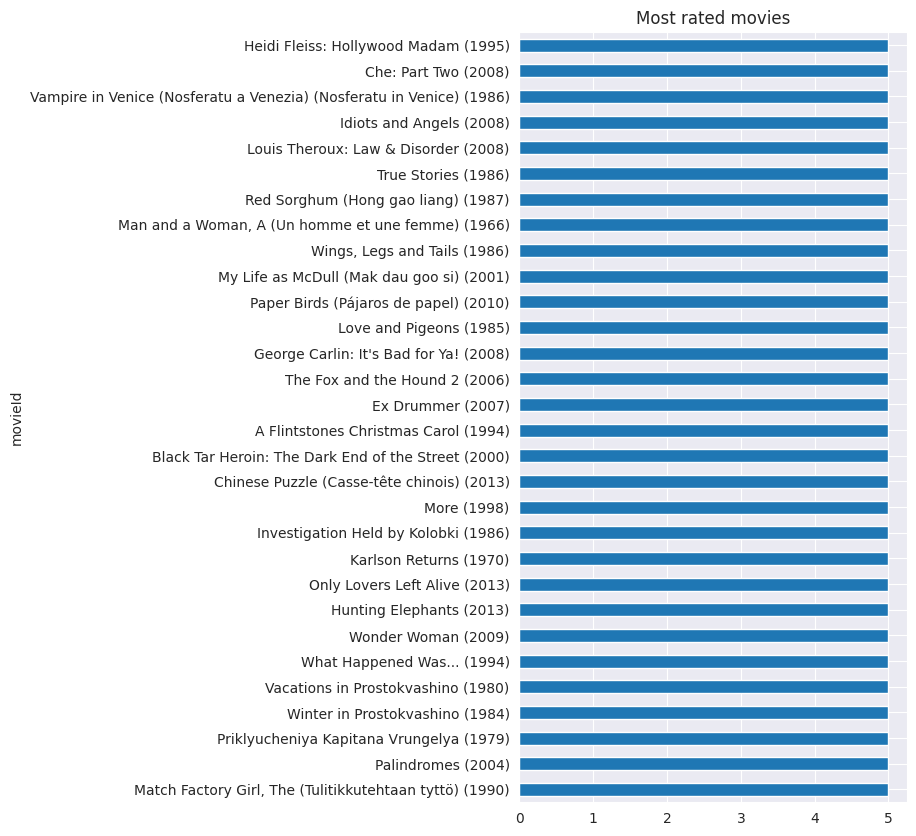

In [14]:
#Most rated movies
temp_df=pivot_df.mean(axis=0).sort_values(ascending=False).head(30)
labels=[dict_idtomovie[x] for x in temp_df.index.to_list()]

fig=plt.figure(figsize=(5,10))
temp_df.plot(kind='barh')
plt.yticks(ticks=range(len(temp_df.index.to_list())),labels=labels,rotation=0)
plt.title('Most rated movies')
plt.gca().invert_yaxis()
plt.show()



Text(0, 0.5, 'Average Rating')

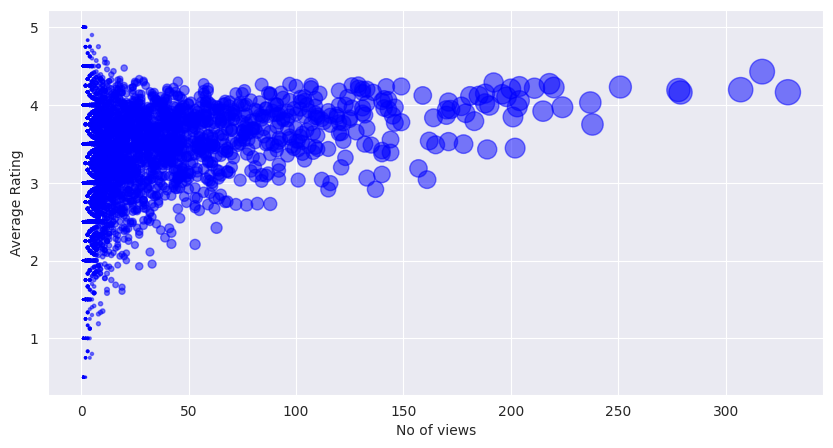

In [15]:
#Correlation between views and ratings
watched_values=pivot_df.count(axis=0).values
rated_values=pivot_df.mean(axis=0).values

fig=plt.figure(figsize=(10,5))
plt.scatter(x=watched_values,y=rated_values,s=watched_values,alpha=0.5,marker='o',c='blue')
plt.xlabel('No of views')
plt.ylabel('Average Rating')

From above graph, it can be seen that although more watched movies have higher rating,therea are also movies with very less views which have higher rating.

In [16]:
#Creating a dictionary to store no of movies viewed per user id
views_per_user=pivot_df.count(axis=1)
dict_user_views=views_per_user.to_dict()


In [17]:
#Creating a dictionary to store no of views per movie id
views_per_movie=pivot_df.count(axis=0)
dict_movie_views=views_per_movie.to_dict()


## Feature Selection for modelling

In [18]:
## Extracting the movie info from movies df

df=rating_df.drop('timestamp',axis=1)
merged_df=df.merge(movie_df,on='movieId',how='left')
merged_df

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,Get Out (2017),Horror
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi


In [19]:
#Defining a function to extract year from title

def extract_year(text):
  year=re.findall(r'\((\d{4})\)',text	)
  if len(year)!=0:
    return int(year[0])
  else:
    return None

In [20]:
merged_df['movie_year']=merged_df['title'].apply(extract_year)
merged_df

,userId,movieId,rating,title,genres,movie_year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,1995.0
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,1995.0
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995.0
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995.0
...,...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller,2017.0
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller,2017.0
100833,610,168250,5.0,Get Out (2017),Horror,2017.0
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017.0


In [21]:
#Extracting genres
list_genres=merged_df['genres'].apply(lambda x:x.split('|')).to_list()
list_all=[]
for l in list_genres:
  list_all.extend(l)

genres_list=list(set(list_all))
genres_list.remove('(no genres listed)')

In [22]:
#Obtaining the genre list

from collections import Counter
Counter(list_all)


Counter({'Adventure': 24161,
         'Animation': 6988,
         'Children': 9208,
         'Comedy': 39053,
         'Fantasy': 11834,
         'Romance': 18124,
         'Action': 30635,
         'Crime': 16681,
         'Thriller': 26452,
         'Mystery': 7674,
         'Horror': 7291,
         'Drama': 41928,
         'War': 4859,
         'Western': 1930,
         'Sci-Fi': 17243,
         'Musical': 4138,
         'Film-Noir': 870,
         'IMAX': 4145,
         'Documentary': 1219,
         '(no genres listed)': 47})

In [30]:
#Separatating the genres into individual columns to input as one-hot encoded
merged_df['genres_dict']=merged_df['genres'].apply(lambda x:Counter(x.split('|')))
new_cols = merged_df['genres_dict'].apply(pd.Series)
new_df=pd.concat([merged_df,new_cols],axis=1)

#dropping genres columns
new_df=new_df.drop(['genres_dict','genres'],axis=1)

new_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,userId,movieId,rating,title,movie_year,Adventure,Animation,Children,Comedy,Fantasy,...,Horror,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,(no genres listed)
0,1,1,4.0,Toy Story (1995),1995.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3,4.0,Grumpier Old Men (1995),1995.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,6,4.0,Heat (1995),1995.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),1995.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,50,5.0,"Usual Suspects, The (1995)",1995.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#Adding the moview viewed counts and user view counts as features
new_df['user_view_count']=new_df['userId'].map(dict_user_views)
new_df['movie_view_count']=new_df['movieId'].map(dict_movie_views)


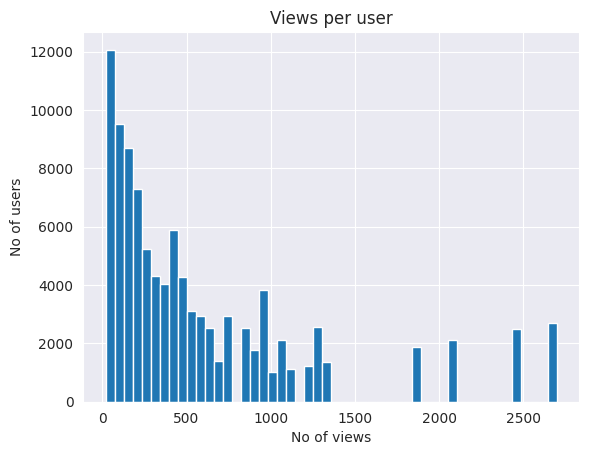

In [32]:
new_df['user_view_count'].plot(kind='hist',bins=50)
plt.title('Views per user')
plt.xlabel('No of views')
plt.ylabel('No of users')
plt.show()

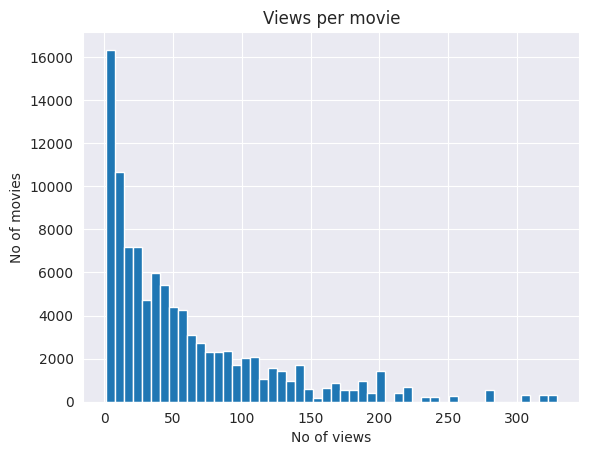

In [33]:
new_df['movie_view_count'].plot(kind='hist',bins=50)
plt.title('Views per movie')
plt.xlabel('No of views')
plt.ylabel('No of movies')
plt.show()

### Cleaning data

In [34]:
#Checking year nan
new_df['movie_year'].isnull().sum()

18

In [35]:
#Dropping movies where year is nan
new_df=new_df.dropna(axis=0,subset=['movie_year'])


In [36]:
#Dropping no genres
new_df=new_df.drop(['(no genres listed)'],axis=1)
new_df.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,userId,movieId,rating,title,movie_year,Adventure,Animation,Children,Comedy,Fantasy,...,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,user_view_count,movie_view_count
0,1,1,4.0,Toy Story (1995),1995.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232,215
1,1,3,4.0,Grumpier Old Men (1995),1995.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232,52
2,1,6,4.0,Heat (1995),1995.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232,102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),1995.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232,203
4,1,50,5.0,"Usual Suspects, The (1995)",1995.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232,204


In [37]:
#Replacing nan with 0

new_df=new_df.replace(np.nan,0)
new_df

,userId,movieId,rating,title,movie_year,Adventure,Animation,Children,Comedy,Fantasy,...,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,user_view_count,movie_view_count
0,1,1,4.0,Toy Story (1995),1995.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232,215
1,1,3,4.0,Grumpier Old Men (1995),1995.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232,52
2,1,6,4.0,Heat (1995),1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232,102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232,203
4,1,50,5.0,"Usual Suspects, The (1995)",1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),2017.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1302,6
100832,610,168248,5.0,John Wick: Chapter Two (2017),2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1302,7
100833,610,168250,5.0,Get Out (2017),2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1302,15
100834,610,168252,5.0,Logan (2017),2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1302,25


In [38]:
print(f"No of users:{new_df['userId'].nunique()}")
print(f"No of movies:{new_df['movieId'].nunique()}")

No of users:610
No of movies:9711


**Since we will be feeding the features into a neural network, it is important to represent the user id and movie id as a continous series of positive integers ,along with 0, for creating embedding matrix**

In [39]:
#Creating the dict for movie so that embedding can be performed as embeddings range from 0 to max(unique)-1
dict_movidxtoid={i:n.item() for i,n in enumerate(sorted(list(new_df['movieId'].unique())))}
dict_movidtoidx={n:i for i,n in dict_movidxtoid.items()}

dict_movidxtoname={i:dict_idtomovie[n] for i,n in dict_movidxtoid.items()}
dict_movnametoidx={m:i for i,m in dict_movidxtoname.items()}


In [40]:
#Creating the dict for users so that embedding can be performed as embeddings range from 0 to max(unique)-1

dict_useridxtoid={i:n for i,n in enumerate(sorted(list(new_df['userId'].unique())))}
dict_useridtoidx={n:i for i,n in dict_useridxtoid.items()}

In [41]:
new_df['user_idx']=new_df['userId'].map(dict_useridtoidx)

new_df['movie_idx']=new_df['movieId'].map(dict_movidtoidx)

In [42]:
#Checking for continuos user_id
new_df['user_idx'].agg(['max','min'])

max    609
min      0
Name: user_idx, dtype: int64

In [43]:
#Checking for continuos movie_id
new_df['movie_idx'].agg(['max','min'])

max    9710
min       0
Name: movie_idx, dtype: int64

In [44]:
new_df.head()

,userId,movieId,rating,title,movie_year,Adventure,Animation,Children,Comedy,Fantasy,...,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,user_view_count,movie_view_count,user_idx,movie_idx
0,1,1,4.0,Toy Story (1995),1995.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,215,0,0
1,1,3,4.0,Grumpier Old Men (1995),1995.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,52,0,2
2,1,6,4.0,Heat (1995),1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,102,0,5
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,203,0,43
4,1,50,5.0,"Usual Suspects, The (1995)",1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,204,0,46


In [45]:
#Selecting the features
features=['user_idx','movie_idx','movie_year','user_view_count','movie_view_count']+genres_list

X=new_df[features].astype('float')
y=new_df['rating']

In [46]:
#Splitting into train and test
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1,shuffle=True,random_state=42)

In [47]:
#Standard scaling the inputs
sscaler=StandardScaler()

In [48]:
#Using movie count as weight vector
X_train_weight=X_train['movie_view_count'].copy()
X_test_weight=X_test['movie_view_count'].copy()

#Scaling the tensors except embeddings
X_train_scaled=sscaler.fit_transform(X_train.iloc[:,2:])
X_train.iloc[:,2:]=X_train_scaled
X_test_scaled=sscaler.transform(X_test.iloc[:,2:])
X_test.iloc[:,2:]=X_test_scaled

In [49]:
#Store scaler values
dict_scaler={}
for i,f in enumerate(sscaler.get_feature_names_out()):
    data_mean=sscaler.mean_
    data_scale=sscaler.scale_
    dict_scaler[f]={'mean':data_mean[i],'scale':data_scale[i]}

dict_scaler

{'movie_year': {'mean': 1994.4463278081466, 'scale': 14.362616996112049},
 'user_view_count': {'mean': 603.7336999647329, 'scale': 652.6040909155598},
 'movie_view_count': {'mean': 58.7929928584024, 'scale': 61.97389706264786},
 'Thriller': {'mean': 0.26265208957855757, 'scale': 0.44007495886334513},
 'Musical': {'mean': 0.041306647857520716, 'scale': 0.19899851431680463},
 'Action': {'mean': 0.30444366073003, 'scale': 0.4601714008620358},
 'Crime': {'mean': 0.16535884323752426, 'scale': 0.37150409984369237},
 'Children': {'mean': 0.09159539763710103, 'scale': 0.2884539491301903},
 'Comedy': {'mean': 0.38794965614530064, 'scale': 0.4872829983100618},
 'Western': {'mean': 0.01881281960853465, 'scale': 0.13586352500546783},
 'Drama': {'mean': 0.4149180038793864, 'scale': 0.49270787890608353},
 'Romance': {'mean': 0.17961999647328514, 'scale': 0.38387062057446153},
 'IMAX': {'mean': 0.041273584905660375, 'scale': 0.19892228657115224},
 'Adventure': {'mean': 0.23969538000352672, 'scale': 0

In [50]:
#Saving in json
dict_scaler_path=pathlib.Path('/kaggle/working/dict_scaler.json')
dict_scaler_path.parent.mkdir(parents=True,exist_ok=True)
with open(dict_scaler_path,'w') as f:
  json.dump(dict_scaler,f)

In [51]:
#Converting to tensors
X_train=torch.tensor(np.array(X_train))
y_train=torch.tensor(np.array(y_train))
X_train_weight=torch.tensor(np.array(X_train_weight))

X_test=torch.tensor(np.array(X_test))
y_test=torch.tensor(np.array(y_test))
X_test_weight=torch.tensor(np.array(X_test_weight))

In [52]:
#Creating Dataset
train_ds=TensorDataset(X_train,y_train,X_train_weight)
test_ds=TensorDataset(X_test,y_test,X_test_weight)

In [53]:
print(f'Length of train_ds={len(train_ds)}')
print(f'Shape of train_ds features={train_ds[:][0].shape}')
print(f'Shape of train_ds weights={train_ds[:][1].shape}')
print(f'Shape of train_ds targets={train_ds[:][2].shape}')

Length of train_ds=90736
Shape of train_ds features=torch.Size([90736, 24])
Shape of train_ds weights=torch.Size([90736])
Shape of train_ds targets=torch.Size([90736])


In [54]:
#Creating dataloaders
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True)
test_dl=DataLoader(test_ds,batch_size=64)

In [55]:
print(f'Shape of a batch:{next(iter(train_dl))[0].shape}')

Shape of a batch:torch.Size([64, 24])


In [56]:
sample_dl_X=next(iter(train_dl))[0]


## Defining the model


In [57]:
from torch import nn

In [58]:
movie_unique=new_df['movie_idx'].nunique()
user_unique=new_df['user_idx'].nunique()
n_features=X_train.shape[1]
embedding_dim=150

f_out=1024
print(f'movie_unique:{movie_unique}\nuser_unique:{user_unique}\nn_features:{n_features}')


movie_unique:9711
user_unique:610
n_features:24


In [59]:
class RatingModel(nn.Module):
  def __init__(self,n_features,movie_unique,user_unique,n_layers=3,dropout=0.2,f_out=f_out,user_embed_dim=150,movie_embed_dim=150):
    super().__init__()

    #Creating movie embeddings
    self.movie_embed=nn.Embedding(num_embeddings=movie_unique,embedding_dim=movie_embed_dim)
    #Creating user embeddings
    self.user_embed=nn.Embedding(num_embeddings=user_unique,embedding_dim=user_embed_dim)

    f_in=n_features+(user_embed_dim-1)+(movie_embed_dim-1)

    #Batch normalizing input
    self.bn1= nn.BatchNorm1d(f_in)

    #Creating a fc layer
    list_layer=[]
    for layer in range(n_layers):
      list_layer.append(nn.Linear(in_features=f_in,out_features=f_out,bias=False))
      list_layer.append(nn.BatchNorm1d(f_out))
      list_layer.append(nn.ReLU())
      if dropout is not None:
        list_layer.append(nn.Dropout(dropout))
      f_in=f_out

    self.fc=nn.Sequential(*list_layer)


    self.final=nn.Sequential(
         nn.Linear(in_features=f_out,out_features=f_out//2,bias=False),
         nn.BatchNorm1d(f_out//2),
         nn.ReLU(),
         nn.Linear(in_features=f_out//2,out_features=1)
        )




  def forward(self,x):
    #Extracting features
    user_id=x[:,0].to(torch.int32)
    movie_id=x[:,1].to(torch.int32)
    movie_year=x[:,2].unsqueeze(1)
    user_view=x[:,3].unsqueeze(1)
    movie_view=x[:,4].unsqueeze(1)
    movie_feat=x[:,5:]

    #Embedding ids
    user_enc=self.user_embed(user_id)
    movie_enc=self.movie_embed(movie_id)

    #Concat after embedding
    x_concat=torch.cat([user_enc,movie_enc,movie_year,user_view,movie_view,movie_feat],dim=1).to(torch.float32)
    x=self.bn1(x_concat)

    #Feed forward through layers
    x=self.fc(x)
    x=self.final(x)


    return x




In [60]:
#Initilaizing model
model=RatingModel(n_features,movie_unique,user_unique,n_layers=5,dropout=0.4,f_out=512,user_embed_dim=50,movie_embed_dim=50).to(device)

In [61]:
model(sample_dl_X.to(device)).shape

torch.Size([64, 1])

In [62]:
torchinfo.summary(model=model,input_data=sample_dl_X.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
RatingModel                              [64, 1]                   --
├─Embedding: 1-1                         [64, 50]                  30,500
├─Embedding: 1-2                         [64, 50]                  485,550
├─BatchNorm1d: 1-3                       [64, 122]                 244
├─Sequential: 1-4                        [64, 512]                 --
│    └─Linear: 2-1                       [64, 512]                 62,464
│    └─BatchNorm1d: 2-2                  [64, 512]                 1,024
│    └─ReLU: 2-3                         [64, 512]                 --
│    └─Dropout: 2-4                      [64, 512]                 --
│    └─Linear: 2-5                       [64, 512]                 262,144
│    └─BatchNorm1d: 2-6                  [64, 512]                 1,024
│    └─ReLU: 2-7                         [64, 512]                 --
│    └─Dropout: 2-8                      [64, 512]          

**Defining Loss Function**

While creating loss function, it is important to note that as there are quite a few movies with very low views and a very high rating, if we use a simple loss function without weights,the model may train to predict a very high rating for these movies across all users.
To counter this, the movies with higher view counts have been given higher weightage, so that more accurate prediction is derived for these movies.

In [63]:
#Defining a weighted loss fn
def weighted_mse_loss(predictions, targets, weights):
    return torch.mean(weights * (predictions - targets)**2)

In [64]:
optimizer=torch.optim.AdamW(model.parameters())

loss_fn=weighted_mse_loss

metrics=torchmetrics.MeanAbsoluteError().to(device)

scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [65]:
#Defining  function to train


def train_model(model,train_dl,optimizer,loss_fn,metrics):
  model.train()
  metrics.reset()
  train_loss=0

  for X,y,w in train_dl:
    X,y,w=X.to(device),y.to(device),w.to(device)
    y_pred=model(X)
   
    #Calculating loss
    batch_loss=loss_fn(predictions=y_pred.squeeze(1),targets= y,weights=w)

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    #updating metrics
    mae=metrics(y_pred.squeeze(1),y)

    train_loss+=batch_loss*X.size(0)

  train_loss=train_loss/len(train_dl.dataset)
  train_mae=metrics.compute()

  return train_loss,train_mae






In [66]:
#Testing the model


def test_model(model,test_dl,loss_fn,metrics):
  model.eval()

  with torch.no_grad():

    metrics.reset()
    test_loss=0

    for X,y,w in test_dl:
      X,y,w=X.to(device),y.to(device),w.to(device)
      y_pred=model(X)
        
      #Calculating loss
      batch_loss=loss_fn(predictions=y_pred.squeeze(1),targets= y,weights=w)


      #updating metrics
      mae=metrics(y_pred.squeeze(1),y)

      test_loss+=batch_loss*X.size(0)

    test_loss=test_loss/len(test_dl.dataset)
    test_mae=metrics.compute()

    return test_loss,test_mae

In [67]:
def train_test_model(model,train_dl,test_dl,optimizer,loss_fn,metrics,epochs,scheduler=None):
  for n in range(epochs):

    train_loss,train_mae=train_model(model,train_dl,optimizer,loss_fn,metrics)
    test_loss,test_mae=test_model(model,test_dl,loss_fn,metrics)
    if scheduler:
      scheduler.step()
    print(f'Epoch:{n} | Train_loss:{train_loss:.2f} | Test_loss:{test_loss:.2f} | Train_MAE:{train_mae:.2f} | Test_MAE:{test_mae:.2f}')



In [74]:
#Testing the model and functions
train_test_model(model,train_dl,test_dl,optimizer,loss_fn,metrics,epochs=10,scheduler=scheduler)

Epoch:0 | Train_loss:69.71 | Test_loss:50.31 | Train_MAE:0.88 | Test_MAE:0.76
Epoch:1 | Train_loss:52.63 | Test_loss:46.75 | Train_MAE:0.78 | Test_MAE:0.73
Epoch:2 | Train_loss:48.04 | Test_loss:45.12 | Train_MAE:0.74 | Test_MAE:0.72
Epoch:3 | Train_loss:45.68 | Test_loss:43.54 | Train_MAE:0.73 | Test_MAE:0.71
Epoch:4 | Train_loss:43.62 | Test_loss:42.49 | Train_MAE:0.71 | Test_MAE:0.71
Epoch:5 | Train_loss:42.16 | Test_loss:41.10 | Train_MAE:0.70 | Test_MAE:0.69
Epoch:6 | Train_loss:40.66 | Test_loss:40.47 | Train_MAE:0.69 | Test_MAE:0.68
Epoch:7 | Train_loss:39.54 | Test_loss:40.12 | Train_MAE:0.68 | Test_MAE:0.68
Epoch:8 | Train_loss:38.62 | Test_loss:40.22 | Train_MAE:0.68 | Test_MAE:0.68
Epoch:9 | Train_loss:38.14 | Test_loss:39.89 | Train_MAE:0.67 | Test_MAE:0.68


## Hyperparamter tuning

In [75]:
def objective(trial):
    # Hyperparameters to tune
    n_layers=trial.suggest_int('n_layers', 2, 10, step=1)
    f_out=trial.suggest_int('f_out', 256, 1024,step= 128)
    dropout=trial.suggest_float('dropout',0.1,0.4,step=0.1)
    user_embed_dim=trial.suggest_int('user_embed_dim', 50, 400,step= 50)
    movie_embed_dim=trial.suggest_int('movie_embed_dim', 50, 400,step= 50)
    learning_rate_exp = trial.suggest_int('lr', -4, -1, step=1)
    learning_rate=10**learning_rate_exp

    #Splitting data in train and val groups
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    fold_scores = []

    #Splitting data in train and val groups
    for train_index, val_index in kf.split(X_train):
      X_train_t,X_val=X_train[train_index],X_train[val_index]
      y_train_t,y_val=y_train[train_index],y_train[val_index]
      X_train_weight_t,X_val_weight=X_train_weight[train_index],X_train_weight[val_index]

    #Creating dataset
      train_t_ds=TensorDataset(X_train_t,y_train_t,X_train_weight_t)
      val_ds=TensorDataset(X_val,y_val,X_val_weight)

    #Creating dataloader
      train_dl=DataLoader(train_t_ds,batch_size=64,shuffle=True)
      val_dl=DataLoader(val_ds,batch_size=64)

    #Initilaizing model
      model=RatingModel(n_features,movie_unique,user_unique,n_layers=n_layers,dropout=dropout,f_out=f_out,user_embed_dim=user_embed_dim,movie_embed_dim=movie_embed_dim).to(device)
      optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
      loss_fn=weighted_mse_loss
      scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
      metrics=torchmetrics.MeanAbsoluteError().to(device)

      #Training model
      for n in range(10):

        train_loss,train_mae=train_model(model,train_dl,optimizer,loss_fn,metrics)
        val_loss,val_mae=test_model(model,val_dl,loss_fn,metrics)
        if scheduler:
          scheduler.step()
      #Appending each fold score
     
      fold_scores.append(val_loss.item())

    return sum(fold_scores) / len(fold_scores)


In [76]:
study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2025-05-17 11:54:18,792] A new study created in memory with name: no-name-133fdf95-e7fd-4068-b937-726a58706eef
[I 2025-05-17 11:58:59,811] Trial 0 finished with value: 47.093697829644576 and parameters: {'n_layers': 4, 'f_out': 768, 'dropout': 0.30000000000000004, 'user_embed_dim': 150, 'movie_embed_dim': 400, 'lr': -4}. Best is trial 0 with value: 47.093697829644576.
[I 2025-05-17 12:03:20,206] Trial 1 finished with value: 40.447029362505354 and parameters: {'n_layers': 3, 'f_out': 896, 'dropout': 0.30000000000000004, 'user_embed_dim': 150, 'movie_embed_dim': 300, 'lr': -2}. Best is trial 1 with value: 40.447029362505354.
[I 2025-05-17 12:08:21,829] Trial 2 finished with value: 42.22819505427027 and parameters: {'n_layers': 5, 'f_out': 896, 'dropout': 0.2, 'user_embed_dim': 50, 'movie_embed_dim': 250, 'lr': -3}. Best is trial 1 with value: 40.447029362505354.
[I 2025-05-17 12:12:21,345] Trial 3 finished with value: 66.78583675618799 and parameters: {'n_layers': 2, 'f_out': 256, 'dr

In [77]:
study.best_params

{'n_layers': 6,
 'f_out': 384,
 'dropout': 0.30000000000000004,
 'user_embed_dim': 300,
 'movie_embed_dim': 50,
 'lr': -2}

In [71]:
#Defining model path
model_save_path= pathlib.Path('/kaggle/working/movie_rec.pt')
model_config_path=pathlib.Path('/kaggle/working/movie_rec_config.json')
model_save_path.parent.mkdir(parents=True,exist_ok=True)

In [113]:
#Saving model config
model_config={
    'n_features':24,
    'movie_unique':9711,
    'user_unique':610,
    'n_layers':int(6),
    'dropout':0.3,
    'f_out':384,
    'user_embed_dim':300,
    'movie_embed_dim':50
}

#Saving in a json file
with open(model_config_path,'w') as f:
  json.dump(model_config,f)

In [114]:
def save_best_model(params_dict,epochs,patience,lr,model_save_path):
  n_features,movie_unique,user_unique,n_layers,dropout,f_out,user_embed_dim,movie_embed_dim=params_dict.values()
 

  #Initializing model
  model=RatingModel(n_features,movie_unique,user_unique,n_layers,dropout,f_out,user_embed_dim=user_embed_dim,movie_embed_dim=movie_embed_dim).to(device)

  optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
  scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

  loss_fn=weighted_mse_loss

  metrics=torchmetrics.MeanAbsoluteError().to(device)

  #Defining

  best_loss=np.inf
  c=0
  

  
  for n in range(epochs):

      train_loss,train_mae=train_model(model,train_dl,optimizer,loss_fn,metrics)
      test_loss,test_mae=test_model(model,test_dl,loss_fn,metrics)
      if scheduler:
        scheduler.step()
      print(f'Epoch:{n} | Train loss:{train_loss:.2f} | Train MAE:{train_mae:.2f} | Test loss:{test_loss:.2f} | Test MAE:{test_mae:.2f}')
    
      if test_loss<best_loss:
        best_loss=test_loss
        best_model=model
      else:
        c+=1
        if c>patience:
          break


  torch.save(best_model.state_dict(),model_save_path)




In [115]:
#Loading config
with open(model_config_path, 'r') as file:
        config_dict = json.load(file)

In [116]:
#Running and saving model
params_dict=config_dict
epochs=50
patience=10
lr=1e-2
save_best_model(params_dict,epochs,patience,lr,model_save_path)


Epoch:0 | Train loss:56.82 | Train MAE:0.80 | Test loss:42.87 | Test MAE:0.70
Epoch:1 | Train loss:43.11 | Train MAE:0.70 | Test loss:40.32 | Test MAE:0.68
Epoch:2 | Train loss:41.43 | Train MAE:0.68 | Test loss:40.74 | Test MAE:0.68
Epoch:3 | Train loss:40.40 | Train MAE:0.67 | Test loss:39.02 | Test MAE:0.67
Epoch:4 | Train loss:39.28 | Train MAE:0.66 | Test loss:38.69 | Test MAE:0.66
Epoch:5 | Train loss:38.46 | Train MAE:0.66 | Test loss:39.61 | Test MAE:0.66
Epoch:6 | Train loss:37.22 | Train MAE:0.65 | Test loss:39.53 | Test MAE:0.66
Epoch:7 | Train loss:36.41 | Train MAE:0.64 | Test loss:37.83 | Test MAE:0.65
Epoch:8 | Train loss:35.52 | Train MAE:0.63 | Test loss:38.44 | Test MAE:0.66
Epoch:9 | Train loss:34.80 | Train MAE:0.63 | Test loss:38.35 | Test MAE:0.65
Epoch:10 | Train loss:34.20 | Train MAE:0.62 | Test loss:38.57 | Test MAE:0.66
Epoch:11 | Train loss:33.89 | Train MAE:0.62 | Test loss:38.50 | Test MAE:0.66
Epoch:12 | Train loss:33.23 | Train MAE:0.61 | Test loss:38.11

In [121]:
#Pre-trained path
model_pretrained_path=pathlib.Path('/kaggle/input')/'movie_recommendation_weighted'/'pytorch'/'default'/'1'/'movie_rec.pt'
#model_pretrained_path=pathlib.Path('/kaggle/working')/'movie_rec.pt'

In [122]:
model_path=model_pretrained_path
#Loading pre_trained model
trained_model=RatingModel(**model_config).to(device)
trained_model.load_state_dict(torch.load(model_path,weights_only=True))


<All keys matched successfully>

In [123]:
torchinfo.summary(trained_model)

Layer (type:depth-idx)                   Param #
RatingModel                              --
├─Embedding: 1-1                         485,550
├─Embedding: 1-2                         183,000
├─BatchNorm1d: 1-3                       744
├─Sequential: 1-4                        --
│    └─Linear: 2-1                       142,848
│    └─BatchNorm1d: 2-2                  768
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       147,456
│    └─BatchNorm1d: 2-6                  768
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       147,456
│    └─BatchNorm1d: 2-10                 768
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      147,456
│    └─BatchNorm1d: 2-14                 768
│    └─ReLU: 2-15                        --
│    └─Dropout: 2-16                

In [124]:
loss_fn=weighted_mse_loss
metrics=torchmetrics.MeanAbsoluteError().to(device)

test_loss,test_mae=test_model(model=trained_model,test_dl=test_dl,loss_fn=loss_fn,metrics=metrics)
print(f'Test MAE:{test_mae.item():.2f}')

Test MAE:0.65


**The Mean Absolute Error obtained on test set is 0.65**

## Building the recommender function

In [125]:
#Creating paths for saving watched movies
watched_movies_path=pathlib.Path('/kaggle/working/watched_movies.csv')
watched_movies_path.parent.mkdir(parents=True,exist_ok=True)

#Creating paths for saving  movies list
movies_path=pathlib.Path('/kaggle/working/movies_list.csv')
movies_path.parent.mkdir(parents=True,exist_ok=True)

#Creating paths for saving  users list
users_path=pathlib.Path('/kaggle/working/users_list.csv')
users_path.parent.mkdir(parents=True,exist_ok=True)

In [126]:
#Getting the last formatted df
new_df

,userId,movieId,rating,title,movie_year,Adventure,Animation,Children,Comedy,Fantasy,...,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,user_view_count,movie_view_count,user_idx,movie_idx
0,1,1,4.0,Toy Story (1995),1995.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,215,0,0
1,1,3,4.0,Grumpier Old Men (1995),1995.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,52,0,2
2,1,6,4.0,Heat (1995),1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,102,0,5
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,203,0,43
4,1,50,5.0,"Usual Suspects, The (1995)",1995.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,232,204,0,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1302,6,609,9409
100832,610,168248,5.0,John Wick: Chapter Two (2017),2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1302,7,609,9435
100833,610,168250,5.0,Get Out (2017),2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1302,15,609,9436
100834,610,168252,5.0,Logan (2017),2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1302,25,609,9437


In [127]:
#Saving the watched movies df to csv
new_df.to_csv(watched_movies_path,index=None)

In [128]:
#Loading  the watched movies df
watched_df=pd.read_csv(watched_movies_path)

In [129]:
#Getting a list of movies the user has seen and their ratings
def show_top_rated_movies(user_id,df):

  temp_df=df[df['userId']==user_id][['title','rating']].sort_values(by='rating',ascending=False)
  top_rating=max(temp_df['rating'])
  top_df=temp_df[temp_df["rating"]==top_rating]
  print(f'You have watched {len(temp_df)} movies.\nHere is your list of {len(top_df)} movies with a rating of {top_rating}:\n{top_df["title"].values}')


In [130]:
user_id=6
df=watched_df
show_top_rated_movies(user_id,df)

You have watched 314 movies.
Here is your list of 40 movies with a rating of 5.0:
['Ghost (1990)' 'Aladdin (1992)' 'Dances with Wolves (1990)'
 'First Wives Club, The (1996)' 'First Knight (1995)'
 'Hunchback of Notre Dame, The (1996)' 'Braveheart (1995)'
 'Copycat (1995)' 'Little Princess, A (1995)' 'Mrs. Doubtfire (1993)'
 'Miracle on 34th Street (1994)' 'Jurassic Park (1993)'
 'Houseguest (1994)' 'Tombstone (1993)' 'Dolores Claiborne (1995)'
 'Shawshank Redemption, The (1994)' 'Stargate (1994)'
 'Secret of Roan Inish, The (1994)' "What's Eating Gilbert Grape (1993)"
 'Tommy Boy (1995)' 'Fugitive, The (1993)' 'Client, The (1994)'
 "City Slickers II: The Legend of Curly's Gold (1994)"
 'Clear and Present Danger (1994)' 'Forrest Gump (1994)' 'Speed (1994)'
 'Maverick (1994)' 'Lion King, The (1994)' 'Just Cause (1995)'
 'Congo (1995)' 'Ghost and the Darkness, The (1996)'
 'Oliver & Company (1988)' 'Dead Man Walking (1995)'
 'Aristocats, The (1970)' 'White Squall (1996)'
 'Independence D

In [131]:
#Getting a list of all movies

movies_features=['movieId','movie_idx','title','movie_year','movie_view_count']+genres_list
movies_df=new_df[movies_features]
#Getting unique movies list
movies_df=movies_df.drop_duplicates(subset=['movieId'])
#Saving to a list
movies_df.to_csv(movies_path,index=None)

#Loading to a df
movies_list_df=pd.read_csv(movies_path)
movies_list_df

,movieId,movie_idx,title,movie_year,movie_view_count,Thriller,Musical,Action,Crime,Children,...,IMAX,Adventure,Fantasy,Horror,Mystery,War,Sci-Fi,Animation,Film-Noir,Documentary
0,1,0,Toy Story (1995),1995.0,215,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,2,Grumpier Old Men (1995),1995.0,52,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,5,Heat (1995),1995.0,102,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47,43,Seven (a.k.a. Se7en) (1995),1995.0,203,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,50,46,"Usual Suspects, The (1995)",1995.0,204,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9706,160341,9301,Bloodmoon (1997),1997.0,1,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9707,160527,9306,Sympathy for the Underdog (1971),1971.0,1,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9708,160836,9318,Hazard (2005),2005.0,1,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9709,163937,9364,Blair Witch (2016),2016.0,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
#Getting a list of all users

users_features=['userId','user_idx','user_view_count']
users_df=new_df[users_features]
#Getting unique users list
users_df=users_df.drop_duplicates(subset=['userId'])
#Saving to a list
users_df.to_csv(users_path,index=None)

#Loading to a df
users_list_df=pd.read_csv(users_path)
users_list_df


,userId,user_idx,user_view_count
0,1,0,232
1,2,1,29
2,3,2,39
3,4,3,216
4,5,4,44
...,...,...,...
605,606,605,1115
606,607,606,187
607,608,607,831
608,609,608,37


In [133]:
#Defining a function to create a df to be set as input

def create_input_df(watched_df,movies_list_df,users_list_df,feature_list,user_id):
  #Selecting user_id
  user_selected_df=users_list_df[users_list_df['userId']==user_id]

  #Selecting watched movie df
  watched_movie_df=watched_df[watched_df['userId']==user_id]


  #Selecting non_watched movies
  not_watched_df=movies_list_df[~movies_list_df['movieId'].isin(watched_movie_df['movieId'])]


  #Performing cross join
  user_selected_df.loc[:,'key']=1
  not_watched_df.loc[:,'key']=1
  cross_df=pd.merge(user_selected_df,not_watched_df,on='key').drop('key',axis=1)
  cross_df

  #Reordering the features
  final_df=cross_df.loc[:,feature_list]
  final_df

  return final_df

In [134]:
final_df=create_input_df(watched_df,movies_list_df,users_list_df,feature_list=features,user_id=1)
final_df

,user_idx,movie_idx,movie_year,user_view_count,movie_view_count,Thriller,Musical,Action,Crime,Children,...,IMAX,Adventure,Fantasy,Horror,Mystery,War,Sci-Fi,Animation,Film-Noir,Documentary
0,0,277,1994.0,232,317,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1283,1997.0,232,141,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,4607,2003.0,232,131,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,5294,2004.0,232,44,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,6235,2006.0,232,28,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9474,0,9301,1997.0,232,1,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9475,0,9306,1971.0,232,1,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9476,0,9318,2005.0,232,1,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9477,0,9364,2016.0,232,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
scaler_dict_path=pathlib.Path('/kaggle/working/dict_scaler.json')
#Loading config
with open(scaler_dict_path, 'r') as file:
        scaler_dict = json.load(file)

In [136]:
#Scaling df
def scale_input_df(df,scaler_dict):
    scaled_df=df.copy()
    
    for key in scaler_dict.keys():
        scaled_df.loc[:,key]=(df.loc[:,key].astype('float32')-scaler_dict[key]['mean'])/( scaler_dict[key]['scale'])
    return scaled_df

In [137]:
scaled_df=scale_input_df(df=final_df,scaler_dict=scaler_dict)
scaled_df

/tmp/ipykernel_31/361045666.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.56961596 -0.56961596 -0.56961596 ... -0.56961596 -0.56961596
 -0.56961596]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scaled_df.loc[:,key]=(df.loc[:,key].astype('float32')-scaler_dict[key]['mean'])/( scaler_dict[key]['scale'])
/tmp/ipykernel_31/361045666.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4.1663833  1.326478   1.1651198 ... -0.9325377 -0.9325377 -0.9325377]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scaled_df.loc[:,key]=(df.loc[:,key].astype('float32')-scaler_dict[key]['mean'])/( scaler_dict[key]['scale'])


,user_idx,movie_idx,movie_year,user_view_count,movie_view_count,Thriller,Musical,Action,Crime,Children,...,IMAX,Adventure,Fantasy,Horror,Mystery,War,Sci-Fi,Animation,Film-Noir,Documentary
0,0,277,-0.031073,-0.569616,4.166383,-0.596835,-0.207573,-0.661588,2.246654,-0.317539,...,-0.207486,-0.561482,-0.365384,-0.279369,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236
1,0,1283,0.177803,-0.569616,1.326478,-0.596835,-0.207573,-0.661588,-0.445106,-0.317539,...,-0.207486,-0.561482,-0.365384,-0.279369,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236
2,0,4607,0.595554,-0.569616,1.165120,1.675505,-0.207573,1.511516,2.246654,-0.317539,...,-0.207486,-0.561482,-0.365384,-0.279369,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236
3,0,5294,0.665179,-0.569616,-0.238697,1.675505,-0.207573,1.511516,2.246654,-0.317539,...,-0.207486,-0.561482,-0.365384,-0.279369,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236
4,0,6235,0.804429,-0.569616,-0.496870,-0.596835,-0.207573,1.511516,-0.445106,-0.317539,...,-0.207486,-0.561482,-0.365384,-0.279369,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9474,0,9301,0.177803,-0.569616,-0.932538,1.675505,-0.207573,1.511516,-0.445106,-0.317539,...,-0.207486,-0.561482,-0.365384,-0.279369,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236
9475,0,9306,-1.632452,-0.569616,-0.932538,-0.596835,-0.207573,1.511516,2.246654,-0.317539,...,-0.207486,-0.561482,-0.365384,-0.279369,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236
9476,0,9318,0.734804,-0.569616,-0.932538,1.675505,-0.207573,1.511516,-0.445106,-0.317539,...,-0.207486,-0.561482,-0.365384,-0.279369,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236
9477,0,9364,1.500681,-0.569616,-0.932538,1.675505,-0.207573,-0.661588,-0.445106,-0.317539,...,-0.207486,-0.561482,-0.365384,3.579491,-0.287718,-0.223993,-0.45444,-0.27299,-0.092453,-0.111236


In [138]:
input_tensor=torch.tensor(np.array(scaled_df),dtype=torch.int).to(device)
input_tensor.shape

torch.Size([9479, 24])

In [139]:
#Loading config
with open(model_config_path, 'r') as file:
        config_dict = json.load(file)

#Initializing model
rating_model=RatingModel(**config_dict).to(device)
rating_model.load_state_dict(torch.load(model_save_path,weights_only=True))
rating_model.eval()

ratings_pred=rating_model(input_tensor).ravel().detach().cpu().numpy()
final_df.loc[:,'Pred_rating']=np.round(ratings_pred,2)
final_df.sort_values(by='Pred_rating',ascending=False)

,user_idx,movie_idx,movie_year,user_view_count,movie_view_count,Thriller,Musical,Action,Crime,Children,...,Adventure,Fantasy,Horror,Mystery,War,Sci-Fi,Animation,Film-Noir,Documentary,Pred_rating
3935,0,1419,1949.0,232,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.79
8216,0,5404,1936.0,232,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.77
2192,0,210,1994.0,232,29,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.77
3805,0,101,1995.0,232,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.76
4036,0,2702,1925.0,232,7,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,0,1581,1983.0,232,7,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.72
1198,0,622,1996.0,232,82,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.64
4874,0,1445,1985.0,232,10,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.63
1702,0,7461,2010.0,232,7,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.63


In [140]:
def predict_rating(user_id,model,model_save_path,model_config_path,scaler_dict_path,watched_df,movies_list_df,users_list_df,feature_list,recommend_nos):
  #Creating input df
  final_df=create_input_df(watched_df,movies_list_df,users_list_df,feature_list=features,user_id=user_id)

  #Loading config
  with open(scaler_dict_path, 'r') as file:
          scaler_dict = json.load(file)
    
  #Scaling df
  scaled_df=scale_input_df(df=final_df,scaler_dict=scaler_dict)

  #Converting into tensor
  input_tensor=torch.tensor(np.array(scaled_df)).to(device)

  #Loading config
  with open(model_config_path, 'r') as file:
          config_dict = json.load(file)

  #Initializing model
  rating_model=RatingModel(**config_dict).to(device)
  rating_model.load_state_dict(torch.load(model_save_path,weights_only=True))
  rating_model.eval()

  #Predicting
  ratings_pred=rating_model(input_tensor).ravel().detach().cpu().numpy()

  #Adding a rating column
  final_df.loc[:,'Pred_rating']=np.round(ratings_pred,2)
  final_df=final_df.sort_values(by='Pred_rating',ascending=False)

  #Merging with movie columns
  recommend_df=final_df.merge(movies_list_df[['title','movie_idx']],how='inner',on='movie_idx')[['title','Pred_rating','movie_view_count']].head(recommend_nos)


  #print(f"Following movies are recommended:{recommend_df['title'].to_list()}")

  return recommend_df




In [141]:
user_id=1
model_save_path=model_save_path
model_config_path=model_config_path
scaler_dict_path=scaler_dict_path
watched_df=watched_df
movies_list_df=movies_list_df
users_list_df=users_list_df
feature_list=features
recommend_nos=50

predict_rating(user_id,model,model_save_path,model_config_path,scaler_dict_path,watched_df,movies_list_df,users_list_df,feature_list,recommend_nos)

/tmp/ipykernel_31/361045666.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.56961596 -0.56961596 -0.56961596 ... -0.56961596 -0.56961596
 -0.56961596]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scaled_df.loc[:,key]=(df.loc[:,key].astype('float32')-scaler_dict[key]['mean'])/( scaler_dict[key]['scale'])
/tmp/ipykernel_31/361045666.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4.1663833  1.326478   1.1651198 ... -0.9325377 -0.9325377 -0.9325377]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scaled_df.loc[:,key]=(df.loc[:,key].astype('float32')-scaler_dict[key]['mean'])/( scaler_dict[key]['scale'])


,title,Pred_rating,movie_view_count
0,"Godfather, The (1972)",4.80,192
1,Hoop Dreams (1994),4.78,29
2,All the King's Men (1949),4.78,4
3,Inside Job (2010),4.76,12
4,Nausicaä of the Valley of the Wind (Kaze no ta...,4.76,23
5,"Godfather: Part II, The (1974)",4.76,129
6,"General, The (1926)",4.76,9
7,Triumph of the Will (Triumph des Willens) (1934),4.75,3
8,"Gold Rush, The (1925)",4.75,7
9,"Good, the Bad and the Ugly, The (Buono, il bru...",4.75,72


## Conclusion

Hence we were able to create a recommender system with 0.65 MAE Score.
One of the main challenge is that some movies with very low views have a very high rating, which is not a representative of its true score.

If we trained the model witout adjusting weights,those few movies with low views and high rating would always show in higher recommendation.

One of the ways in which this could be solved is to ignore the movies with very low score, but in this model, we optimized the model using movie views as weights, so that more more weightage is provided to movies with higher views.

The model is a simple feed forward neural network with parameters derived through hyperparameter tuning.